In [1]:
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical

In [69]:
tf.config.run_functions_eagerly(True)

In [14]:
IMG_SIZE = 48

In [54]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def callback_func(modelName):
  checkpoint = ModelCheckpoint(f"Checkpoints/{modelName}.h5", monitor = "val_accuracy", save_best_only = True, mode = "auto", verbose = 1)
  early_stopping = EarlyStopping(monitor = "val_accuracy", patience = 10, verbose = 1)
  callbacks = [early_stopping, checkpoint]
  return callbacks

In [23]:
def load_dataframe(path):
    classes = os.listdir(path)
    df = pd.DataFrame()
    
    for cls in classes:
        cls_path = os.path.join(path, cls)
        
        if not os.path.isdir(cls_path):
            continue
            
        for file in os.listdir(cls_path):
            image_path = os.path.join(path, cls, file)
            
            if os.path.isfile(image_path):
                image = Image.open(image_path)
                image = np.asarray(image, dtype=np.double)
                image /= 255
                df = df.append(pd.Series({'emotion': cls, 'image': image}), ignore_index=True)
    
    return df

In [5]:
def split_dataframe(df, rate=0.8):
    mask = np.random.rand(len(df)) < rate
    return df[mask], df[~mask]

In [59]:
def preprocess_dataframe(df):    
    X = np.apply_along_axis(lambda row: row.tolist(), 0, df.image.values)
    y = df.emotion.apply(lambda emo: EMOTIONS_MAP[emo]).values.reshape(-1, 1)
    return X, y

In [115]:
def plot_distributions(array1, array2, title1='', title2=''):
    df_array1 = pd.DataFrame()
    df_array2 = pd.DataFrame()
    df_array1['emotion'] = array1.argmax(axis=1)
    df_array2['emotion'] = array2.argmax(axis=1)
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    x = EMOTIONS_MAP.keys()
    
    y = df_array1['emotion'].value_counts()
    keys_missed = list(set(EMOTIONS_MAP.values()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[0].bar(x, y.sort_index(), color='orange')
    axs[0].set_title(title1)
    axs[0].grid()
    
    y = df_array2['emotion'].value_counts()
    keys_missed = list(set(EMOTIONS_MAP.values()).difference(set(y.keys())))
    for key_missed in keys_missed:
        y[key_missed] = 0
    axs[1].bar(x, y.sort_index())
    axs[1].set_title(title2)
    axs[1].grid()
    
    plt.show()

In [112]:
def plot_predicted(images, emotions, y_pred, index):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=False)
    
    bar_label = list(EMOTIONS_MAP.keys())
    
    axs[0].imshow(images[index], 'gray')
    axs[0].set_title(bar_label[np.where(emotions[index] == 1)[0][0]])
    
    axs[1].bar(bar_label, y_pred[index], color='orange', alpha=0.7)
    axs[1].grid()
    
    plt.show()

In [24]:
df_train = load_dataframe('data/train')
df_test, df_validation = split_dataframe(load_dataframe('data/test'))

In [127]:
EMOTIONS_MAP = {emotion: i for i, emotion in enumerate(df_train.emotion.unique())}
EMOTIONS_MAP

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [60]:
X_train, y_train = preprocess_dataframe(df_train)
X_test, y_test = preprocess_dataframe(df_test)
X_validation, y_validation = preprocess_dataframe(df_validation)

In [64]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_validation = to_categorical(y_validation)

In [65]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_validation.shape, y_validation.shape

((28709, 48, 48),
 (28709, 7),
 (5732, 48, 48),
 (5732, 7),
 (1446, 48, 48),
 (1446, 7))

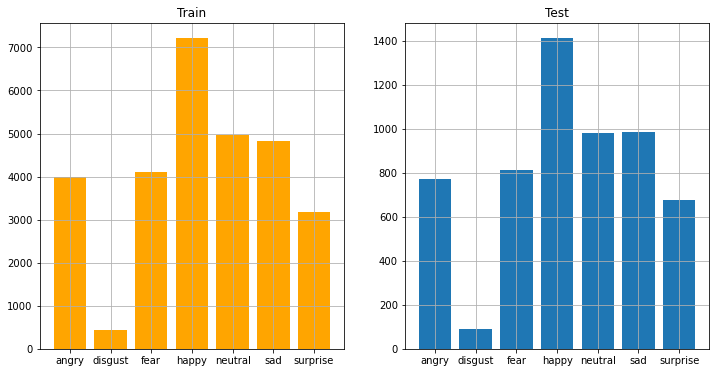

In [118]:
plot_distributions(y_train, y_test, 'Train', 'Test')

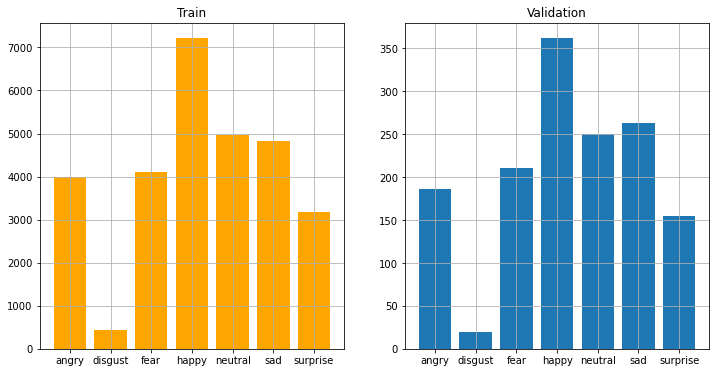

In [119]:
plot_distributions(y_train, y_validation, 'Train', 'Validation')

In [49]:
class_weight = dict(zip(range(0, 7), (((df_train['emotion'].value_counts()).sort_index())/len(df_train['emotion'])).tolist()))
class_weight

{0: 0.1391549688251071,
 1: 0.01518687519593159,
 2: 0.14270786164617366,
 3: 0.2513149186666202,
 4: 0.17294228290779895,
 5: 0.16823992476226968,
 6: 0.11045316799609878}

In [50]:
model = models.Sequential()

model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1)))
model.add(Dropout(0.25))

model.add(MaxPool2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(MaxPool2D((2, 2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Dropout(0.25))

model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(7, activation='softmax'))

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 dropout (Dropout)           (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        36928     
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                    

In [52]:
model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
history = model.fit(X_train, y_train,
                    validation_data=(X_validation, y_validation),
                    callbacks=callback_func('C1'),
                    class_weight = class_weight,
                    epochs=50,
                    batch_size=64)

Epoch 1/50


C:\Users\kirill-korolev\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


449/449 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.2953
Epoch 1: val_accuracy improved from -inf to 0.39557, saving model to Checkpoints\C1.h5
449/449 [==============================] - 309s 689ms/step - loss: 0.2753 - accuracy: 0.2953 - val_loss: 1.5949 - val_accuracy: 0.3956
Epoch 2/50
449/449 [==============================] - ETA: 0s - loss: 0.2300 - accuracy: 0.4207
Epoch 2: val_accuracy improved from 0.39557 to 0.45574, saving model to Checkpoints\C1.h5
449/449 [==============================] - 291s 649ms/step - loss: 0.2300 - accuracy: 0.4207 - val_loss: 1.4385 - val_accuracy: 0.4557
Epoch 3/50
449/449 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.4701
Epoch 3: val_accuracy improved from 0.45574 to 0.47994, saving model to Checkpoints\C1.h5
449/449 [==============================] - 288s 640ms/step - loss: 0.2105 - accuracy: 0.4701 - val_loss: 1.4024 - val_accuracy: 0.4799
Epoch 4/50
449/449 [==============================]

In [72]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('Training Accuracy:', train_acc*100)
print('\n')

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Testing Accuracy:', test_acc*100)
print('\n')

val_loss, val_acc = model.evaluate(X_validation, y_validation)
print('Validation Accuracy:', val_acc*100)

898/898 [==============================] - 104s 116ms/step - loss: 0.5836 - accuracy: 0.8274
Training Accuracy: 82.7440857887268


180/180 [==============================] - 22s 119ms/step - loss: 1.1748 - accuracy: 0.5843
Testing Accuracy: 58.4263801574707


46/46 [==============================] - 5s 115ms/step - loss: 1.0802 - accuracy: 0.6003
Validation Accuracy: 60.02766489982605


In [74]:
y_pred = model.predict(X_test)

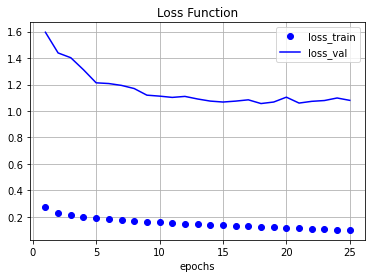

In [76]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('Loss Function')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

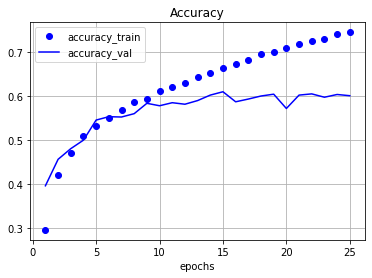

In [77]:
acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.legend()
plt.grid()
plt.show()

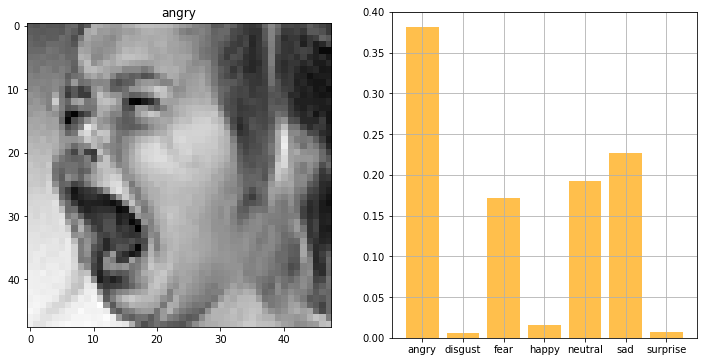

In [113]:
plot_predicted(X_test, y_test, y_pred, 21)

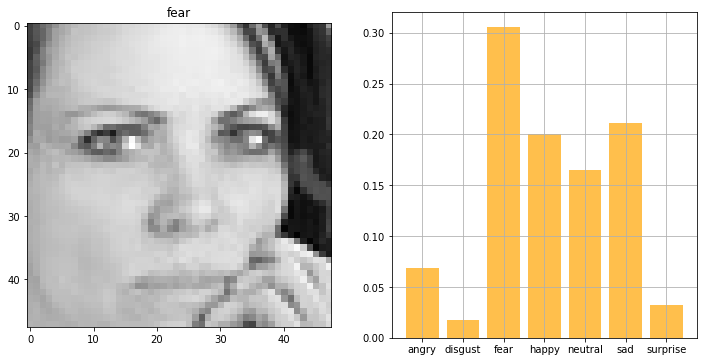

In [114]:
plot_predicted(X_test, y_test, y_pred, 960)

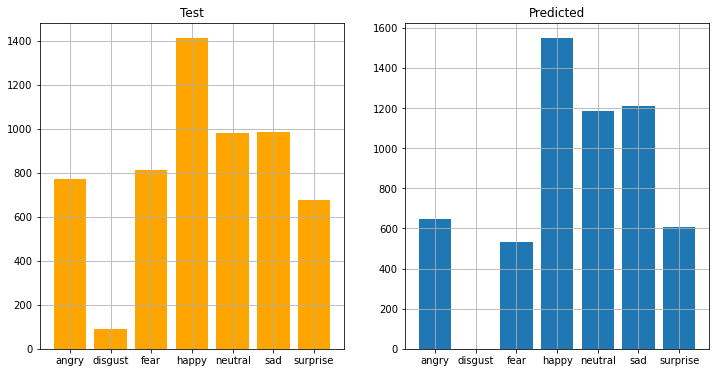

In [117]:
plot_distributions(y_test, y_pred, 'Test', 'Predicted')

In [121]:
model.save('bin/model')

INFO:tensorflow:Assets written to: bin/model\assets


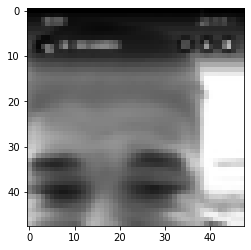

In [170]:
from skimage.transform import resize

image = np.asarray(Image.open('C:/Users/kirill-korolev/Pictures/yan.jpg').convert('L'), dtype=np.double)
image /= 255
N = min(image.shape[0], image.shape[1])
image = image[:N, :N]
plt.imshow(resize(image, (48, 48)), cmap='gray')